# Atlethic / Sedentary Classification using Fully Connected Neural Networks
## Elaborated by: Antonio Alvarez

The current project seeks to establish a fully connected neural network (FCNN) capable of distinguishing between a person that is physically active from someone that is sedentary. For that we use a database with series of anthropometric measures from which we extract the most prominent attributes using an autoencoder after preprocessing the dataset.

I will be using pandas and numpy to pre-process the dataset, sklearn for the main FCNN and pytorch for the autoencoder.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.preprocessing as pre
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp

Variables related to the monte carlo experiment

In [2]:
NUM_TRIALS = 10
nn_accuracy = np.zeros(NUM_TRIALS)
nn_precision = np.zeros(NUM_TRIALS)
nn_recall = np.zeros(NUM_TRIALS)
nn_f1 = np.zeros(NUM_TRIALS)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

1. We read the table as a pandas dataframe, drop the instances that don't have a label for physical activities and drop the attributes with missing entries. 
2. We drop the least important variables according to the autoencoder in the second section of the notebook, center to mean and unit variance and convert to a float numpy matrix. 
3. Finally, we convert the labels for physical activities to numbers for the network.

In [3]:
table = pd.read_csv('database.csv',na_values=
                    ['NA','NaN','.','?',' ','#VALUE!']).dropna(
                    subset=['Act Fis']).dropna(axis=1)

#'EDADDEC','EDADCOD','PESO','TALLA', 'TALLA m','IMC'

"""'SEXO', 'EDADDEC',
       'EDADCOD', 'PESO', 'TALLA', 'TALLA m', 'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
       'TRICEPSI', 'IMC', 'Contextura'"""

X = pre.scale(table.drop(columns=['Act Fis','Muestra','FICHA',
                                  'ESC','Procedencia','EDADDEC','PESO', 'TALLA',
                                  'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
                                  'TRICEPSI', 'IMC']).to_numpy().astype(float))
y = table['Act Fis'].to_numpy()

le = pre.LabelEncoder()
le.fit(y)
y = le.transform(y)

We split the dataset using stratification to preserve the proportions between the classes: 80% for the training set and 20% for the test set

We set the FCNN, this network has 200 neurons in the first hidden layer, 100 in the second and 50 in the third. The hidden layers also use RELU as the activation function, Adam as the optimizing algorithm and the default values according to sklearn for momentum and regularization.

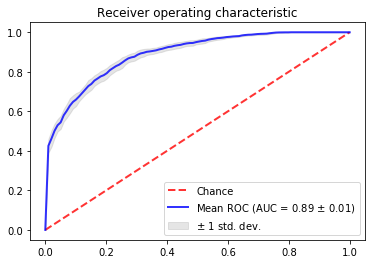

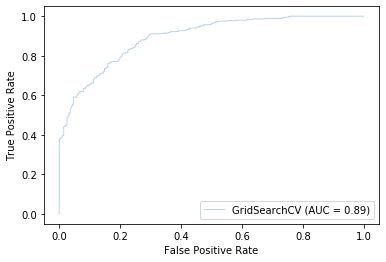

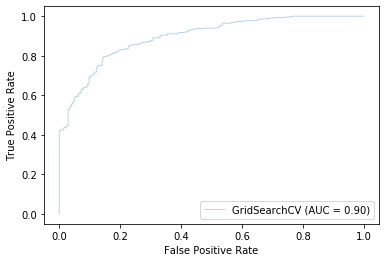

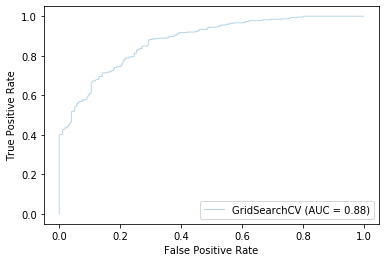

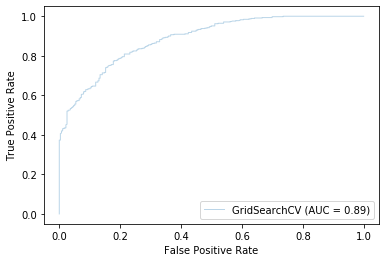

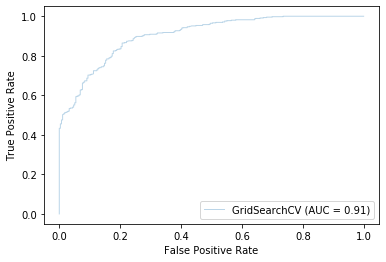

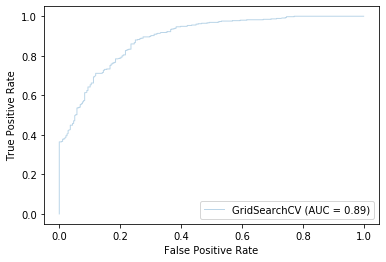

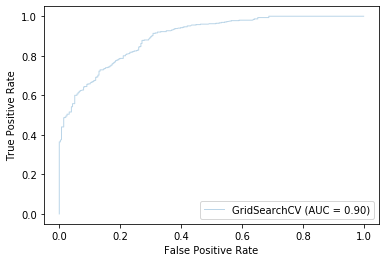

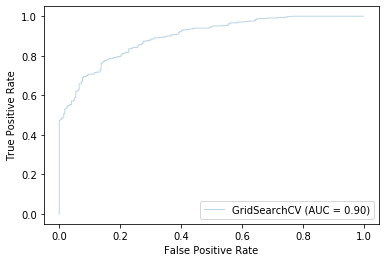

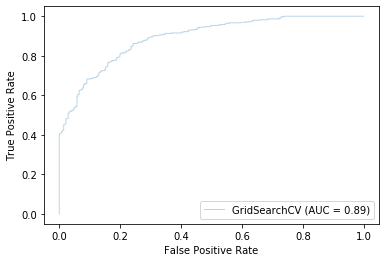

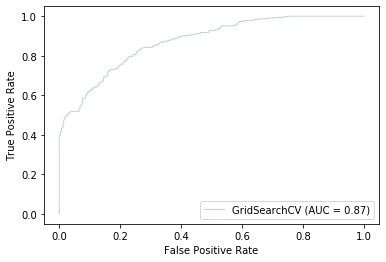

Mean accuracy is: 0.81
Mean Precision is:0.82
Mean Recall is:0.88
Mean F1 is:0.83


In [4]:
fig, ax = plt.subplots()
for i in range(NUM_TRIALS):
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    param_nn = {'alpha': [0.0001], 'hidden_layer_sizes': [(200,100,50,)], 'max_iter':[10000]}
    nn = MLPClassifier()
    cv_nn = GridSearchCV(nn,param_nn,cv=5)
    cv_nn.fit(X_train,y_train)
    
    predicted_nn = cv_nn.predict(X_test)
    nn_accuracy[i] = mt.accuracy_score(y_test,predicted_nn)
    nn_precision[i] = mt.precision_score(y_test,predicted_nn)
    nn_recall[i] = mt.recall_score(y_test,predicted_nn)
    nn_f1 = mt.f1_score(y_test,predicted_nn)
    
    viz = plot_roc_curve(cv_nn, X_test, y_test,
                         alpha=0.3, lw=1)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.savefig("meanROC.png")
plt.show()

print("Mean accuracy is: %0.2f" % nn_accuracy.mean())
print("Mean Precision is:%0.2f" % nn_precision.mean())
print("Mean Recall is:%0.2f" % nn_recall.mean())
print("Mean F1 is:%0.2f" % nn_f1.mean())

## Selección de atributos

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
class Encoder(nn.Module):
    """ Encoder that reduces an input from 12 dimensions to 6"""
    
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc = nn.Linear(12,4)
        
    def forward(self,input):
        return F.relu(self.fc(input))

In [6]:
class Decoder(nn.Module):
    """ Decoder that reconstructs a 12-dimensional vector from a 6-dimensional input """
    
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc = nn.Linear(4,12)
        
    def forward(self,input):
        return self.fc(input)

In [7]:
def train(encoder,decoder,loader,enc_optimizer,dec_optimizer,criterion,epochs,device):
    """Trains the given model
    
    Args:
        encoder (nn.Module inherited class) : encoder used
        decoder (nn.Module inherited class) : decoder used
        loader (data.DataLoader) : loader used for training 
        enc_optimizer (optim): encoder optimizer
        dec_optimizer (optim): decoder optimizer
        criterion (torch.nn criterion): criterion used for the optimization
        epochs (int): # epochs for training 
        device (torch.device) : device where the computation will take place 
    """
    epoch_values = [] 
    for j in range(epochs):

        running_loss = 0.0
        loss_values = 0
        num_batches = 0
        
        for i, data in enumerate(loader, 0):
    
            inputs = data.to(device)
            
            #We clean the gradients
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            compressed = encoder(inputs) #Encode
            outputs = decoder(compressed) #Decode
            
            loss = criterion(outputs,inputs) #calculate loss
            loss.backward() #backpropagate
            
            #Update weights 
            enc_optimizer.step() 
            dec_optimizer.step()

            running_loss += loss.item()
            loss_values += loss.item()
            num_batches += 1
            if i % 5000 == 4999:
                print('[%d, %5d] loss: %.3f' %
                          (j + 1, i + 1, running_loss / 5000))
                running_loss = 0.0
                
        epoch_values.append(loss_values / num_batches)
                
    print("Finished training") 
    fig, ax = plt.subplots()
    ax.plot(np.array(epoch_values), 'r')
    ax.set(xlabel='Number of epochs', ylabel='MSE',title='Training Error')
    plt.savefig('training_error.png')
    plt.show()

In [8]:
def testing(encoder,decoder,loader,device,remove_outliers=False):
    
    """Tests the given model
    
   Args:
        encoder (nn.Module inherited class) : encoder used
        decoder (nn.Module inherited class) : decoder used
        loader (data.DataLoader) : loader used for testing
        device (torch.device) : device where the computation will take place
        remove_outliers (Bool): flag that determines if the outliers will be removed from the plots 
                                (True) or not (False)
    """

    error_list = []           
    with torch.no_grad():
        for data in loader:
            inputs = data.to(device)
            compressed = encoder(inputs) #Encodes 
            outputs = decoder(compressed) # Decodes
            #Calculate the difference between original and reconstructed instances
            batch_error = inputs - outputs / inputs 
            error_list.append(batch_error)

    attributes = ['SEXO', 'EDADDEC',
       'EDADCOD', 'PESO', 'TALLA', 'TALLA m', 'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
       'TRICEPSI', 'IMC', 'Contextura']
    
    error = torch.cat(error_list,0).numpy()
    if remove_outliers:
        error = error[~is_outlier(error)] #Removes outliers
    instances = range(error.shape[0])
    var_index = 0
    str_outlier = "_without_outliers" if remove_outliers else ""
    
    for i in range(len(attributes)):
        fig, ax = plt.subplots()
        ax.scatter(instances,error[:,var_index])
        ax.set(xlabel='Instances', ylabel='original - uncompressed / original', 
                         title='Variable ' + attributes[var_index])
        plt.savefig('error_' + attributes[var_index] + str_outlier + '.png')
        plt.show()
        var_index += 1


In [10]:
# Taken from : https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
# Credits: Joe Kington

def is_outlier(points, thresh=3):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [11]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [12]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
trainloader = DataLoader(X_train_tensor, batch_size=5, shuffle=True)
testloader = DataLoader(X_test_tensor, batch_size=5, shuffle=True)
encoder = Encoder().to(device)
decoder = Decoder().to(device)
criterion = nn.MSELoss()
enc_optimizer = optim.Adam(encoder.parameters())
dec_optimizer = optim.Adam(decoder.parameters())

Finished training


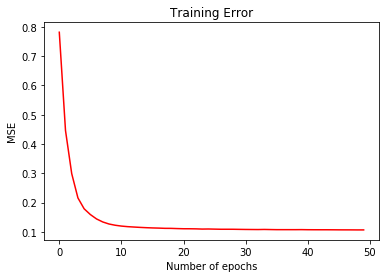

In [13]:
train(encoder,decoder,trainloader,enc_optimizer,dec_optimizer,criterion,50,device)

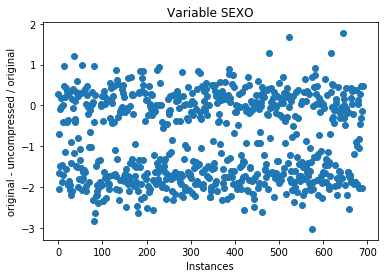

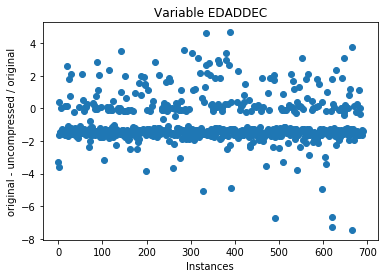

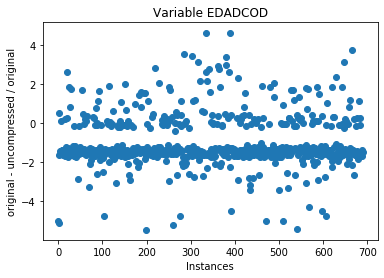

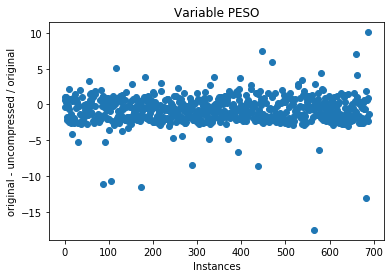

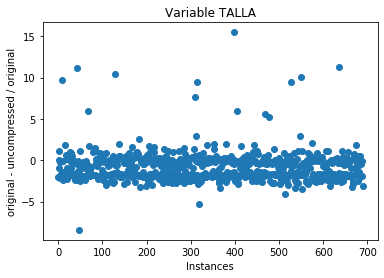

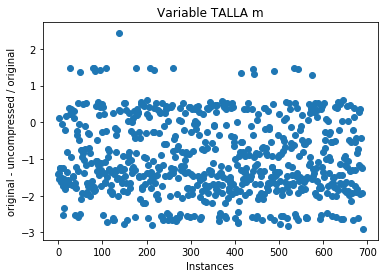

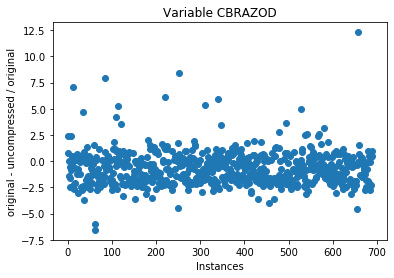

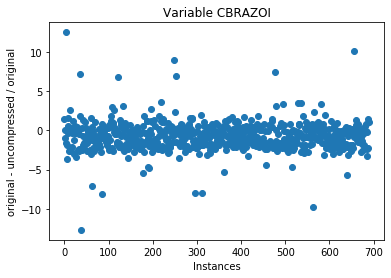

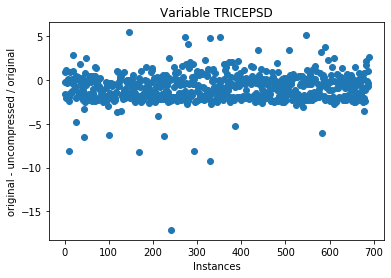

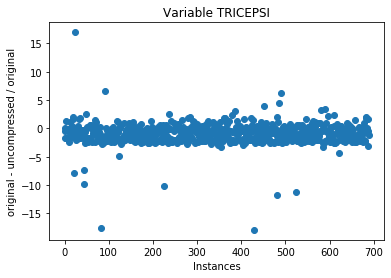

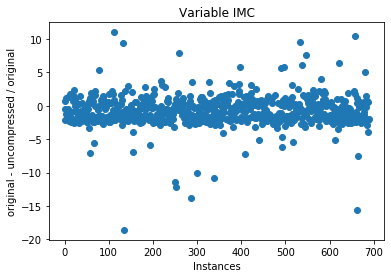

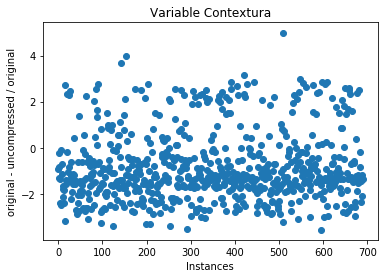

In [14]:
testing(encoder,decoder,testloader,device,True)